In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Notebook to do time series analysis on crime in San Francisco from 2003 - 2017


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

## Import data and look at some trends with time

In [3]:
# Import and turn date and time into single timestamp and then use resampling for plotting
df = pd.read_csv('../../Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv', 
                  parse_dates={'Datetime': ['Date', 'Time']}, infer_datetime_format=True)

# Show all columns of dataframe
pd.set_option('display.max_columns', None)

In [4]:
# Keep columns and sort by date/time
df = df[['Category', 'Descript', 'DayOfWeek', 'Datetime', 'X', 'Y', 'PdDistrict', 'Resolution']]

data = (
    df.dropna()
    .sort_values(by='Datetime')
)

# Set index to datetime object for resampling
data = data.set_index('Datetime')

Text(0, 0.5, 'Counts')

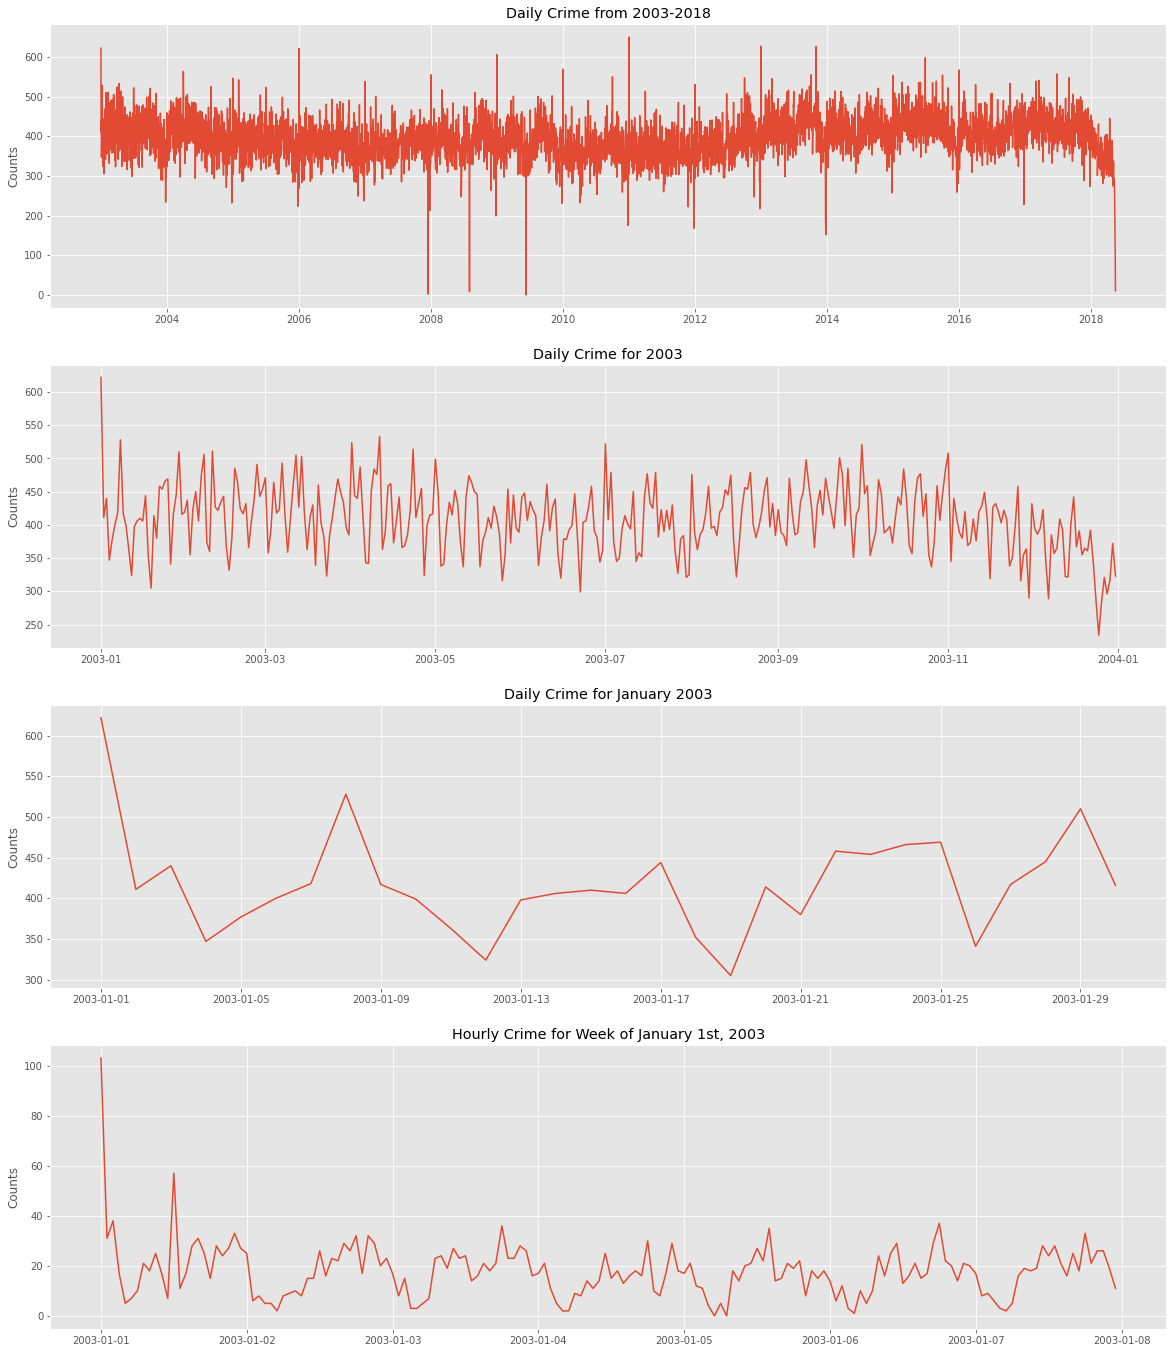

In [5]:
# Plot crimes using resampling
fig, axes = plt.subplots(4, 1, figsize=(20,24))
ax = axes[0]
ax.plot(data.resample('D').count()['Category'])
ax.set_title('Daily Crime from 2003-2018')
ax.set_ylabel('Counts')

ax = axes[1]
ax.plot(data.resample('D').count()['Category'].iloc[0:365])
ax.set_title('Daily Crime for 2003')
ax.set_ylabel('Counts')

ax = axes[2]
ax.plot(data.resample('D').count()['Category'].iloc[0:30])
ax.set_title('Daily Crime for January 2003')
ax.set_ylabel('Counts')

ax = axes[3]
ax.plot(data.resample('H').count()['Category'].iloc[0:168])
ax.set_title('Hourly Crime for Week of January 1st, 2003')
ax.set_ylabel('Counts')

#plt.savefig('../data/images/Crimetrends.png', bbox_inches='tight', dpi=350)

Text(0, 0.5, 'Counts')

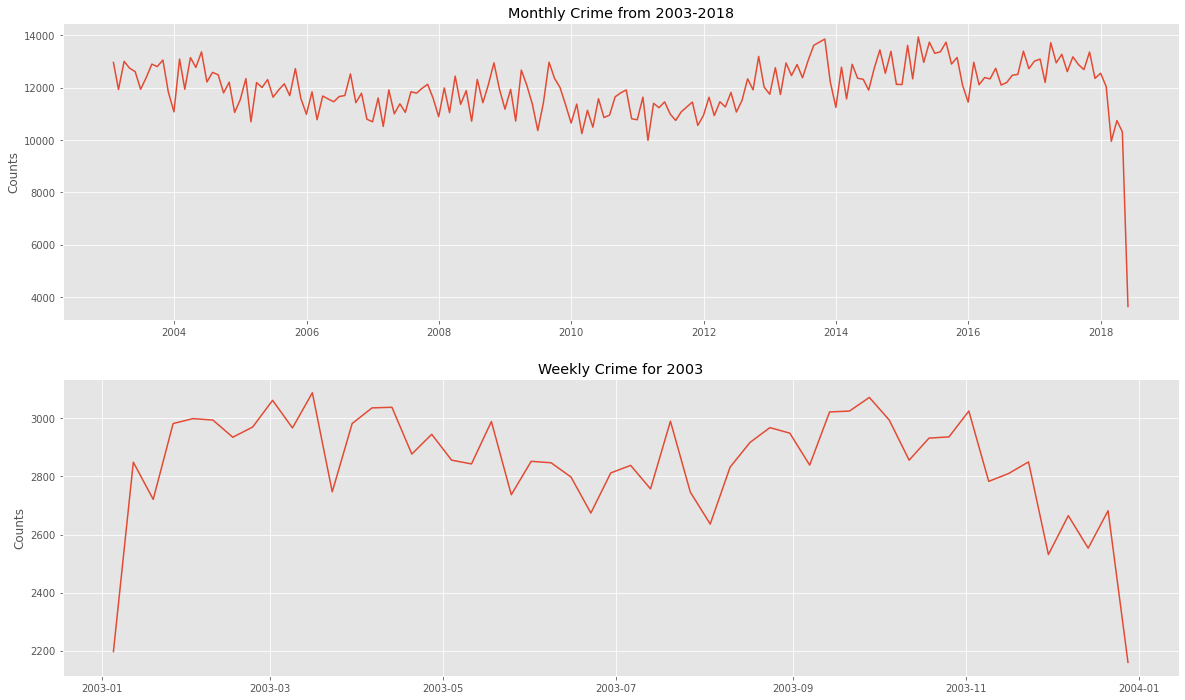

In [6]:
# Breakdown into different timescales
fig, axes = plt.subplots(2, 1, figsize=(20,12))
ax = axes[0]
ax.plot(data.resample('M').count()['Category'])
ax.set_title('Monthly Crime from 2003-2018')
ax.set_ylabel('Counts')

ax = axes[1]
ax.plot(data.resample('W').count()['Category'].iloc[0:52])
ax.set_title('Weekly Crime for 2003')
ax.set_ylabel('Counts')

#plt.savefig('../data/images/Crimetrends2.png', bbox_inches='tight', dpi=350)

In [7]:
# Remove data from 2018 from analysis
data = data.loc[:'2017-12-31']

### Trend Analysis

Looking at the data at various time scales shows that we may have a few different frequency components: hourly, weekly and seasonal.

Let's now explore the following:
- Decompose the data using trend-season-residual decomposition. 
- Check for stationarity
- Do some differencing
- Moving Average and autocorrelation
- ARIMA model (if stationarity proven)

In [8]:
# Start with imports
from scipy import signal
from scipy import stats

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [9]:
# For funsies, let's fit a linear trend line to the data
def fit_linear_trend(series):
    
    # Add in constant/intercept for OLS model
    X = (np.arange(len(series)) + 1).reshape(-1,1)
    X = sm.add_constant(X, prepend=False)
    
    # Fit line
    model = sm.OLS(series.values, X).fit()
    y_hat = model.predict(X)
    
    # Other things we likely don't need
    params = model.params
    
    return y_hat

def plot_series(ax, name, series):
    y_predict = fit_linear_trend(series)
    
    # Plot the data and fit line
    ax.plot(series.index.date, series)
    ax.plot(series.index.date, y_predict)
    ax.set_title(name)

In [10]:
# Redefine our data with monthly resampling
series = data.resample('M').count()['Category']
y_predict = fit_linear_trend(series)

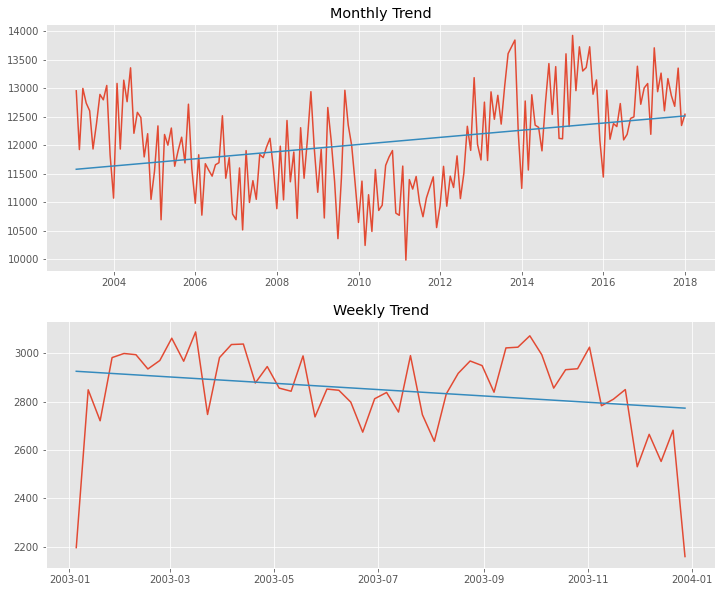

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(12,10))
plot_series(axes[0], 'Monthly Trend', data.resample('M').count()['Category'])
plot_series(axes[1], 'Weekly Trend', data.resample('W').count()['Category'].iloc[:52])

### Trend-Seasonal-Decomposition

In [16]:
# Pick resampling and get decomp
series = data.resample('M').count()['Category'].iloc[:365]
decomp = sm.tsa.seasonal_decompose(series)

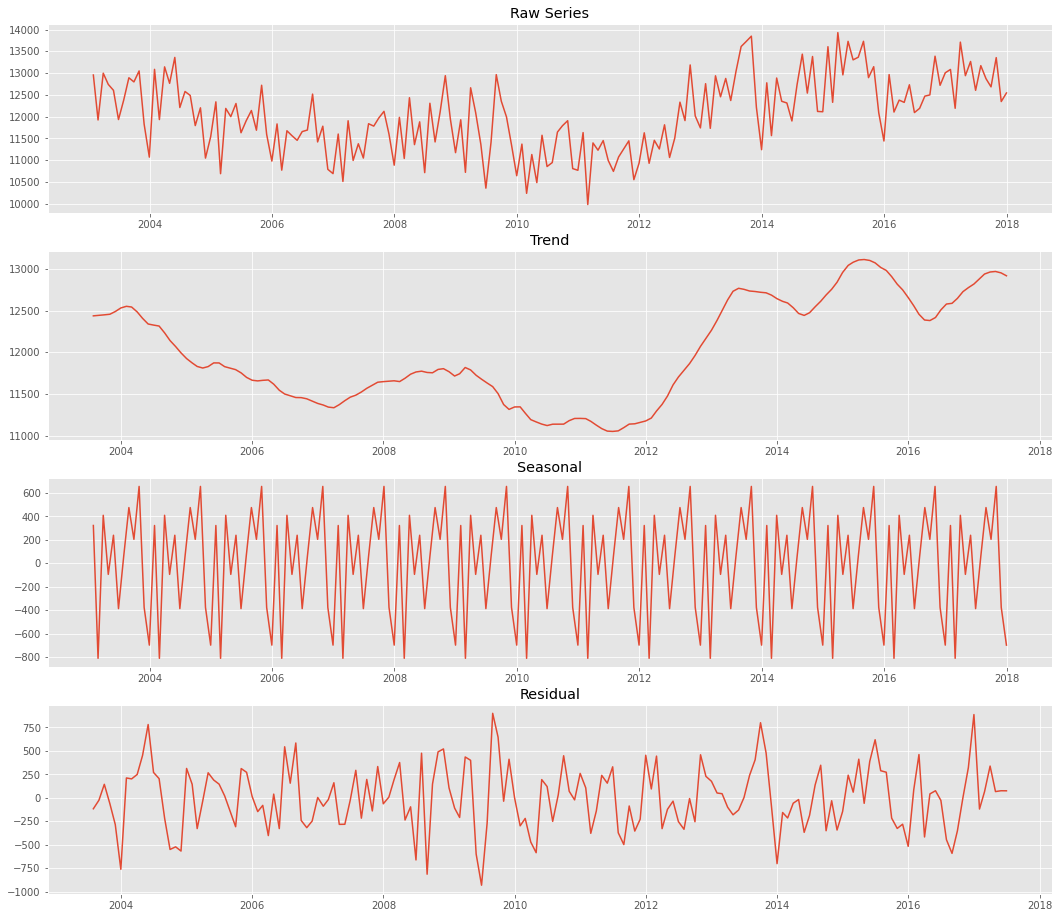

In [17]:
# Statsmodel decomp has 3 components. Let's plot them
fig, axes = plt.subplots(4,1, figsize=(18, 16))

names = ['Raw Series', 'Trend', 'Seasonal', 'Residual']
components = [series, decomp.trend, decomp.seasonal, decomp.resid]

for ax, name, comp in zip(axes, names, components):
    ax.plot(series.index, comp)
    ax.set_title(name)

#plt.savefig('../data/images/tsadecomp_day2.png', bbox_inches='tight', dpi=250)

### Analysis so far

1. We see some pretty strong signals in the decomposition. 
2. There is clearly a trend within our data, which means it's not stationary and thus doesn't satisfy the requirements for ARIMA modeling. 
3. The residual component looks to be quite large (how do we quantify this?), which implies that there is a lot of crime that can't be explained by trend or seasonality. 
4. The sampling on the monthly vs weekly timescale can give us more information, specifically showing perdiodic components on both timescales. 
5. Resampling on a daily basis and then looking at the decomposition shows that there are more crimes reported in the evening (as we saw during EDA).

### Next Steps

1. Check stationarity with Dickey-Fuller Test
2. Look at and plot autocorrelations within the data
3. Make data stationary via differencing
4. Apply ARIMA model
5. Look into other forecasting methods, like LightGBM
6. Look into multivariate methods used for non-stationary data

In [14]:
# Make is easy to sample data at different intervals
def series_sample(series, string):
    return data.resample(string).count()['Category']

In [15]:
# Test stationarity using augmented Dickey-Fuller Test
# Taken from https://github.com/mkpetterson/Collisions_Data/blob/master/Collisions_TimeSeries.ipynb
# H0: Time series is NOT stationary. We want to reject the null. 
# The ADF test statistic is a negative number - the more negative it is, the stronger the rejection of the null hypothesis.


from statsmodels.tsa.stattools import adfuller
X = series
adf_result = adfuller(X)

print(f'test statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(key, value)

test statistic: -1.075817757437565
p-value: 0.7246185451062943
Critical Values:
1% -3.44911857009962
5% -2.8698097654570507
10% -2.5711757061225153


The test statistic is greater than even the 10% confidence level, so we fail to reject the null and can't conclude that the series is stationary.

Onto correlations and differencing:
- Autocorrelations look at the correlation of data with itself
- Partial autocorrelation attempts to remove the linear relationship between serialized observations
- Differencing attempts to stabalize the variance by taking the difference between consecutive observations

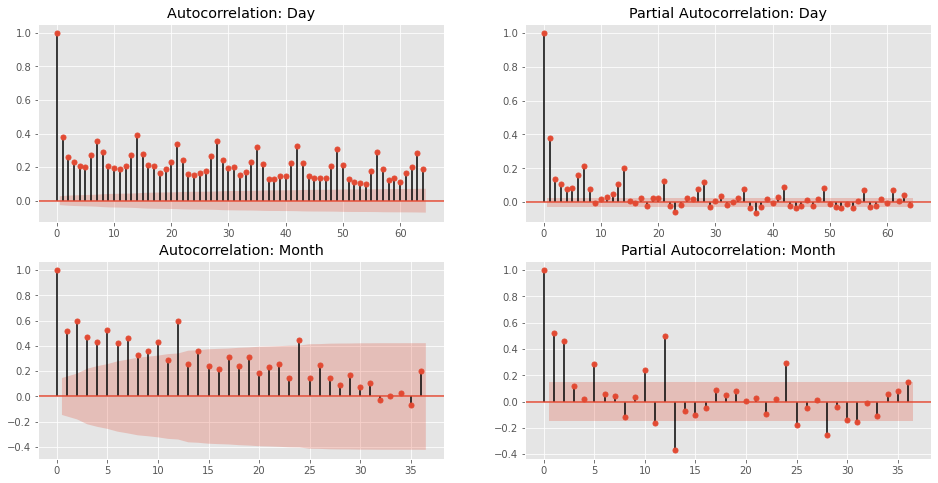

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, axes = plt.subplots(2, 2, figsize=(16,8))

_ = plot_acf(series_sample(data, 'D'), ax=axes[0,0], lags=64,
             title="Autocorrelation: Day")
_ = plot_pacf(series_sample(data, 'D'), ax=axes[0,1], lags=64,
              title="Partial Autocorrelation: Day")

_ = plot_acf(series_sample(data, 'M'), ax=axes[1,0], lags=36,
             title="Autocorrelation: Month")
_ = plot_pacf(series_sample(data, 'M'), ax=axes[1,1], lags=36,
              title="Partial Autocorrelation: Month")

#plt.savefig('../data/images/autocorrelations.png', dpi=250)

### Stationarity
A stationary process is one in which the mean, variance, autocorrelation are all constant with time. Another way to phrase this is that the distribution of all equally spaced tuples are identical (identically distributed). <b> Note that this definition does NOT include independence. It is likely that the sample we draw at time t influences the sample we draw at t+1.</b>


### Autocorrelation vs partial autocorrelation
<b>Autocorrelation</b> is looking at the correlation of the data with itself, lagged by some integer value (x axis).<br>
<b>Partial Autocorrelation</b> attempts to control the dependency between data points by removing the linear relationship between them.  

Note that the first spike at x=0 is always equal to 1. The shaded region is the 95% confidence bounds. <br>
Sampling frequency by day: When sampling by the day, we see spikes at 7 and 14, showing the weekly trend. <br>
Month: If we sample by month, we see spikes at the 12 month mark, although there is pretty high correlation across all months. <br>
Year: Sampling by year shows a strong negative correlation at the 6 year mark, but this likely coincides with the recession of 2008-2010 and isn't a periodic effect.

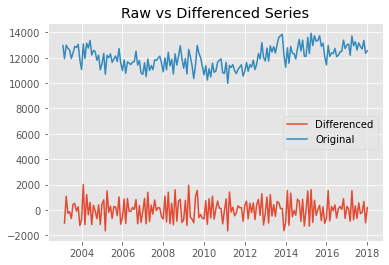

In [18]:
# This pandas method calculates diff of series with self, shifted by 1 (default number)
diff = series_sample(data, 'M').diff()[1:]

# Plot differenced series
plt.plot(diff, label="Differenced")
plt.plot(series_sample(data, 'M'), label="Original")
plt.title('Raw vs Differenced Series')
plt.legend()

#plt.savefig('../data/images/differenced.png', dpi=250)

In [19]:
# Now check for stationarity with DF test
sm.tsa.adfuller(diff)

(-4.820614017978506,
 4.96570212391087e-05,
 11,
 167,
 {'1%': -3.470126426071447,
  '5%': -2.8790075987120027,
  '10%': -2.5760826967621644},
 2518.133031669052)

Our test statistic is more negative and our p-value is close to 0. We can confidently reject the null and now apply the ARIMA model.

### Onto ARIMA!

The goal is to create a model for our data. So....what *can* model a stationary process?

AR: Autoregressive. An autoregressive process often generates stationary data. Subsequent values of the series are linear combinations of previous values of the series plus some noise term. 

$$ y_i = \mu + b_1 y_{i-1} + b_2 y_{i-2} + \cdots + b_k y_{i-k} + \epsilon_i $$

In autocorrelation, you can see the correlation at lower lag values, but the influence does linger. This effect can be controlled with partial autocorrelation.

The number of coefficients is called the order of the model. 

MA: Moving Average can also representa a stationary time series. The series is represented as a linear combination of white noise with coefficients for each term. 

$$ s_i = \mu + e_i + a_1 e_{i-1} + \cdots + a_k e_{i-k} $$

The order of a MA model is typically found by the number of non-zero autocorrelations (non-zero coefficients). 

ARMA: The best of both! 
- Linear combination of white noise (MA component)
- Linear combination of previous terms plus noise term (AR component)

$$ y_i = \mu + \overbrace{e_i + a_1 e_{i-1} + \cdots + a_q e_{i-q}}^{\text{MA component}} + \overbrace{b_1 y_{i-1} + b_2 y_{i-2} + \cdots + b_p y_{i-p} + \epsilon_i}^{\text{AR component}} $$

Add in the I (Integrated):
This offsets the fact that we are differencing our data to make it stationary. 

ARIMA (p, d, q) model:
- differenced d times
- AR has order p
- MA has order q

https://people.duke.edu/~rnau/arimrule.htm#:~:text=Rules%20for%20identifying%20ARIMA%20models&text=General%20seasonal%20models%3A%20ARIMA%20(0,%2C1%2C1)%20etc.&text=Identifying%20the%20order%20of%20differencing%20and%20the%20constant%3A,a%20higher%20order%20of%20differencing.

## Start by finding order or AR and MA for our model

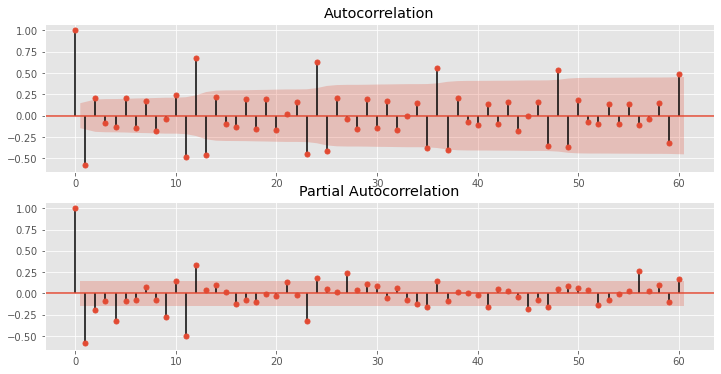

In [20]:
# Plot autocorrelation of differenced data
fig, axes = plt.subplots(2,1, figsize=(12,6))
_ = plot_acf(diff, ax=axes[0], lags=60)
_ = plot_pacf(diff, ax=axes[1], lags=60)

plt.savefig('../data/images/pacf_differenced.png', bbox_inches='tight', dpi=250)

Even in the partial autocorrelation, there are a lot of significant points, however we don't need to difference again because the Dickey-Fuller test showed stationarity. So our order of D is just high: roughly 8.

So far we are at ARIMA(8, 1, 0)

From [here](https://people.duke.edu/~rnau/arimrule.htm#:~:text=Rules%20for%20identifying%20ARIMA%20models&text=General%20seasonal%20models%3A%20ARIMA%20(0,%2C1%2C1)%20etc.&text=Identifying%20the%20order%20of%20differencing%20and%20the%20constant%3A,a%20higher%20order%20of%20differencing.):

"If the series has positive autocorrelations out to a high number of lags (say, 10 or more), then it probably needs a higher order of differencing."

"If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced."

We're ok =)

In [18]:
# Start with this and add in MA if we feel like it. 
# Might need MA of order 1 due to the negative AC @ lag=1

crime_data = series_sample(data, '2M')#[1:-1] # drop first and last due to partial counting
crime_diff = crime_data.diff()[1:]
crime_model = ARIMA(crime_data, order=(8,1,0)).fit()

crime_data

Datetime
2003-01-31    12956
2003-03-31    24922
2003-05-31    25346
2003-07-31    24313
2003-09-30    25691
              ...  
2017-05-31    26208
2017-07-31    25776
2017-09-30    25556
2017-11-30    25702
2018-01-31    12544
Freq: 2M, Name: Category, Length: 91, dtype: int64

In [19]:
crime_model.params
#crime_model.forecast(steps=5)

const              -1.556090
ar.L1.D.Category   -0.299115
ar.L2.D.Category   -0.118813
ar.L3.D.Category   -0.024429
ar.L4.D.Category   -0.282712
ar.L5.D.Category   -0.155118
ar.L6.D.Category    0.159989
ar.L7.D.Category   -0.151901
ar.L8.D.Category   -0.287875
dtype: float64

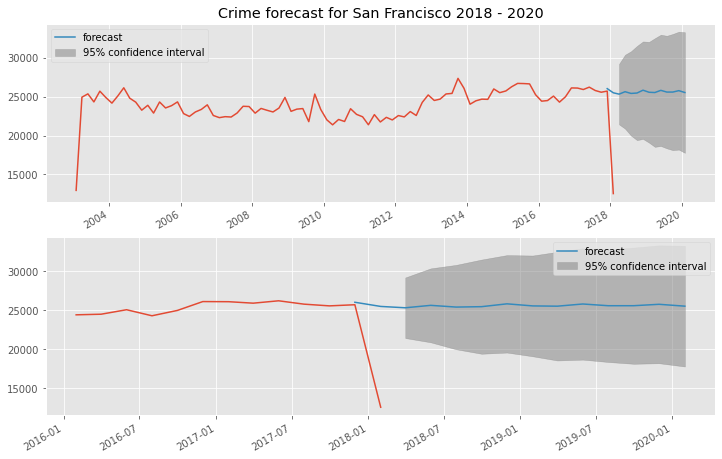

In [20]:
# Fit model to project crime into the future
fig, axes = plt.subplots(2, figsize=(12,8))
ax = axes[0]
ax.plot(crime_data.index, crime_data)

# Set fig = crime_model plot prediction method
fig = crime_model.plot_predict('2017-11-30', '2020',
                                dynamic=True, ax=ax, # Plots in-sample forecast; not lagged
                                plot_insample=False) # Not plotting Category feature
ax.set_title("Crime forecast for San Francisco 2018 - 2020")
ax.legend(loc='upper left')

ax = axes[1]
ax.plot(crime_data['2016':].index, crime_data['2016':])
fig = crime_model.plot_predict('2017-11-30', '2020',
                                dynamic=True, ax=ax, # Plots in-sample forecast; not lagged
                                plot_insample=False) # Not plotting Category feature

#plt.savefig('../data/images/crime_forecast.png', bbox_inches='tight', dpi=250)

NameError: name 'plot_acf' is not defined

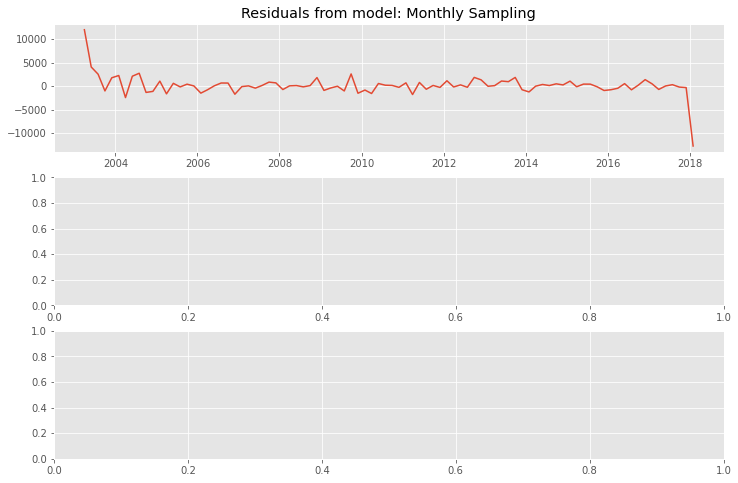

In [21]:
# Look at residuals of model and see if they look like white noise
fig, ax = plt.subplots(3, figsize=(12,8))
ax[0].plot(crime_model.resid.index, crime_model.resid)
ax[0].set_title("Residuals from model: Monthly Sampling")

# Check auto correlation
_ = plot_acf(crime_model.resid, lags=50, ax=ax[1], title="Autocorrelation from residuals")
_ = plot_pacf(crime_model.resid, lags=50, ax=ax[2], title="Partial Autocorrelation from residuals")

plt.tight_layout()

plt.savefig('../data/images/monthly_residuals.png', dpi=250)

Sooooo....this isn't so great. Having several significant points outside of the confidence interval implies our model isn't that great. The residuals of our model should be white noise, ie, no pattern in the components that aren't explained by the model. Autocorrelation of white noise shows a giant peak at lag=0 and the rest of the values should be within the confidence interval.

This plot indicates that there are patterns in our data that aren't accounted for in the model. We can:

1. Change resampling rate (this works! Going to 2M seems to fit the model)
2. Do a model search

### Try to recreate data with our ARIMA model and see how closely it matches
This required a function that takes in our model coefficients and outputs predicted values

In [152]:
# Simulate data and see if it can recreate our crime trends
# http://numpy-discussion.10968.n7.nabble.com/simulate-AR-td8236.html

def auto_regressive_process(size, coefs, init=None):
    
    # Initialize dataset as Gaussian 
    coefs = np.asarray(coefs)
    if init == None:
        init = np.array([0]*len(coefs))
    else:
        init = np.asarray(init)
    init = np.append(init, np.random.normal(size=(size-len(init))))
    assert(len(init) == size)
    a = np.append(np.array([1]), -coefs)
    b = np.array([1])
    
    # lfilter is signal processing method that outputs transposed (shifted) structure
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html#scipy.signal.lfilter
    
    return pd.Series(signal.lfilter(b, a, init))

def plot_autoregressive_model(ax, size, coefs, init=None):
    ar = auto_regressive_process(size, coefs, init)
    ax.plot(ar.index, ar)

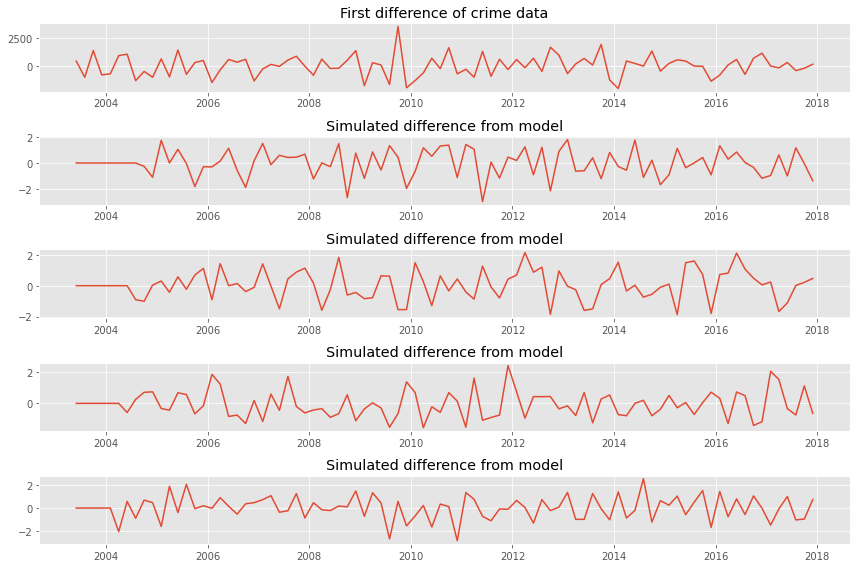

In [153]:
# Plot simulated data - looking at AR
fig, ax = plt.subplots(5, figsize=(12,8))
ax[0].plot(crime_diff.index, crime_diff)
ax[0].set_title("First difference of crime data")

for i in range(1,5):
    sim_data = auto_regressive_process(len(crime_diff), list(crime_model.params)[i:])
    sim_data.index = crime_diff.index
    ax[i].plot(sim_data.index, sim_data)
    ax[i].set_title("Simulated difference from model")
    
plt.tight_layout()

## Model search: optimization and adding seasonality